In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
import json
import pprint
import scipy.stats as stats
import urllib
from urllib.parse import quote
import re
from config import yelp_key

In [7]:
#File with 500 largest population ZIP codes in the USA Code data
file = 'input/zipcodes_all.csv'

df_list = pd.read_csv(file)
df_zip = df_list.iloc[0:100,:]
# Randomly select 100 zipcodes
# df_zip = df_list.sample(100)

zip_count = df_zip.zip_code.count()
print(f"Total zip codes: {zip_count}")
df_zip.head()

Total zip codes: 100


,zip_code,city,latitude,longetude,population,People / Sq. Mile,National Rank,number,State
0,10162,New York,40.769298,-73.949942,1726,151834.77,#1,1,New York
1,10028,New York,40.776865,-73.954721,44987,126067.69,#2,2,New York
2,10128,New York,40.781656,-73.950281,59856,122356.52,#3,3,New York
3,8625,Trenton,40.207185,-74.756664,1834,115477.17,#4,4,New Jersey
4,10031,New York,40.825857,-73.949451,60221,101100.03,#5,5,New York


In [8]:
# Get ready to import yelp data
API_KEY=yelp_key

API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
MATCH_PATH = '/v3/businesses/matches'
SEARCH_PHONE_PATH = '/v3/businesses/search/phone'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash

In [9]:
def request(host, path, api_key, url_params=None):
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }
#     print(u'Querying {0} ...'.format(url))
#     print(headers)

    response = requests.request('GET', url, headers=headers, params=url_params)
    return response.json() #, my_url

In [10]:
df_businesses = pd.DataFrame()
df_bus_total = pd.DataFrame()
prices = []
dict_total = {}

for index, row in df_zip.iterrows():
    row_zip = row[0]
    row_city = row[1]
    row_lat = row[2]
    row_long = row[3]
    #     print(index, row_zip, row_lat, row_long)
    url_params={"city":row_city, 'zip_code':row_zip,'latitude':row_lat,'longitude':row_long}
    dict_businesses = request(API_HOST, SEARCH_PATH, API_KEY, url_params)
    try:
        df_businesses['business_id']=[business["id"] for business in dict_businesses['businesses']]
        df_businesses['name']=[business["name"]for business in dict_businesses['businesses']]
        df_businesses['rating']=[business["rating"]for business in dict_businesses['businesses']]
        df_businesses['zip_code']=[business['location']["zip_code"]for business in dict_businesses['businesses']]
        df_businesses['review_count']=[business["review_count"]for business in dict_businesses['businesses']]
        df_businesses['price']=[business["price"]for business in dict_businesses['businesses']]
    except:
        pass
    
    df_bus_total = df_bus_total.append(df_businesses)

C:\Users\dutch\Anaconda3\envs\PythonData\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [11]:
df_bus_total['price'].value_counts()

$$      1303
$        436
$$$      151
$$$$      50
Name: price, dtype: int64

In [12]:
# Specify the file to write to
output_path = os.path.join("output", "business_data_all.csv")
df_bus_total.to_csv(output_path)

In [13]:
# Drop duplicates
df_bus_total = df_bus_total.sort_values('business_id')
df_bus_total = df_bus_total.reset_index(drop=True)
df_bus_unique = df_bus_total.drop_duplicates(['business_id'], keep='first')

In [14]:
bus_uni_count = df_bus_unique.business_id.count()
print(f"Total unique businesses: {bus_uni_count}")
df_bus_unique.head()
# Optionally use a smaller data set: df_bus_unique_small = df_bus_unique[1:5]

Total unique businesses: 885


,business_id,name,price,rating,review_count,zip_code
0,-DrR38H1Abk0wCyu9XOLug,Sweet Maple,$$,4.0,3588,94115
2,-FOAQv22SXtSBs7nptI3UA,Serious Pie,$$,4.0,4083,98121
3,-LJayGlySYnQ8z2VvZyFNw,Little Vietnam,$,4.5,328,60640
4,-NglVrPdjl3dG-z8ZBzJyQ,The Wilky,$$,4.5,149,11221
6,-OixbLnFLCzQclxCSbUQ8w,Up Thai,NaN,4.5,2180,10021


In [15]:
# Specify the file to write to
output_path = os.path.join("output", "business_unique_data_all.csv")
df_bus_unique.to_csv(output_path)

In [16]:
# Get reviews for each unique business
dict_rev_total = {}
dict_reviews = {}
df_reviews = pd.DataFrame()
df_rev_total = pd.DataFrame()

for index, row in df_bus_unique.iterrows():
    row_bus = row[0]
    REVIEW_PATH = BUSINESS_PATH + row_bus + '/reviews'
    dict_reviews = request(API_HOST, REVIEW_PATH, API_KEY)
    try:
        df_reviews['business_id']= [row_bus for review in dict_reviews['reviews']]
        df_reviews['review_id']=[review["id"]for review in dict_reviews['reviews']]
        df_reviews['rating']=[review["rating"]for review in dict_reviews['reviews']]
        df_reviews['name']=[review['user']["name"]for review in dict_reviews['reviews']]
        df_rev_total = df_rev_total.append(df_reviews)
    except:
        pass

In [17]:
rev_uni_count = df_rev_total.review_id.count()
print(f"Total reviews: {rev_uni_count}")
df_rev_total.head()

Total reviews: 2655


,business_id,review_id,rating,name
0,-DrR38H1Abk0wCyu9XOLug,ZSXojEQF9VbhD_h3K-4bmg,5,Amber S.
1,-DrR38H1Abk0wCyu9XOLug,6YtIAi2jrOWx3yvM9HcJEw,4,Tiffany N.
2,-DrR38H1Abk0wCyu9XOLug,2j1t2s7Mu39N3d0c-SYSOA,4,Holly P.
0,-FOAQv22SXtSBs7nptI3UA,s_NXa4ISlDWd_C0bALRbnQ,5,Valerie S.
1,-FOAQv22SXtSBs7nptI3UA,kKQ5h0SUyhq0PMRXoql0tQ,5,Joanne C.


In [18]:
#COMMENT OUT THE RESET BELOW IF RAN MULTIPLE TIMES!!!!

df_rev_total.reset_index(inplace=True)

# create a list with names per review and take only the name before the 'space' as a first name
df_rev_total['short name']=""
short_name = []
for index, row in df_rev_total.iterrows():
#     print(row)
    short_name = re.split("( )",row[4])
#     print(short_name)
    df_rev_total.iloc[index, 5] = short_name[0].lower()

In [19]:
rev_uni_count = df_rev_total.review_id.count()
print(f"Total reviews: {rev_uni_count}")
df_rev_total.head()

Total reviews: 2655


,index,business_id,review_id,rating,name,short name
0,0,-DrR38H1Abk0wCyu9XOLug,ZSXojEQF9VbhD_h3K-4bmg,5,Amber S.,amber
1,1,-DrR38H1Abk0wCyu9XOLug,6YtIAi2jrOWx3yvM9HcJEw,4,Tiffany N.,tiffany
2,2,-DrR38H1Abk0wCyu9XOLug,2j1t2s7Mu39N3d0c-SYSOA,4,Holly P.,holly
3,0,-FOAQv22SXtSBs7nptI3UA,s_NXa4ISlDWd_C0bALRbnQ,5,Valerie S.,valerie
4,1,-FOAQv22SXtSBs7nptI3UA,kKQ5h0SUyhq0PMRXoql0tQ,5,Joanne C.,joanne


In [20]:
file = 'input/gender names.csv'
df = pd.read_csv(file)
df = df.set_index('first_name')
df.head()

,nameprimary,gender,count
first_name,,,
aa,AA,Not Known,1
aabha,AABHA,Female,1
aabida,AABIDA,Female,1
aad,AAD,Male,1
aadarsh,AADARSH,Male,1


In [21]:
df_rev_total['gender']=""
gender = []
for index, row in df_rev_total.iterrows():
    try:
        gender = df.loc[str(row[5]),'gender']
    #     print(gender)
        df_rev_total.iloc[index, 6] = gender
    except:
        pass
df_rev_total.head()

# Drop reviews with where gender isn't found
df_rev_total = df_rev_total.loc[(df_rev_total['gender']!="") & (df_rev_total['gender']!="Both") & (df_rev_total['gender']!="Not Known")]

In [22]:
# Specify the file to write to
df_rev_total = df_rev_total.rename(columns={'rating':'reviewer_rating', 'name':'reviewer_full'})
output_path = os.path.join("output", "review_by_gender_data_all.csv")
df_rev_total.to_csv(output_path)

rev_gender_count = df_rev_total.review_id.count()
print(f"Total reviews with gender: {rev_gender_count}")

# Specify the file to write to
output_path = os.path.join("output", "review_data_all.csv")
df_rev_total.to_csv(output_path)

df_rev_total.head()

Total reviews with gender: 2066


,index,business_id,review_id,reviewer_rating,reviewer_full,short name,gender
0,0,-DrR38H1Abk0wCyu9XOLug,ZSXojEQF9VbhD_h3K-4bmg,5,Amber S.,amber,Female
1,1,-DrR38H1Abk0wCyu9XOLug,6YtIAi2jrOWx3yvM9HcJEw,4,Tiffany N.,tiffany,Female
2,2,-DrR38H1Abk0wCyu9XOLug,2j1t2s7Mu39N3d0c-SYSOA,4,Holly P.,holly,Female
3,0,-FOAQv22SXtSBs7nptI3UA,s_NXa4ISlDWd_C0bALRbnQ,5,Valerie S.,valerie,Female
4,1,-FOAQv22SXtSBs7nptI3UA,kKQ5h0SUyhq0PMRXoql0tQ,5,Joanne C.,joanne,Female


In [23]:
df_total = pd.merge(df_rev_total, df_bus_unique,on=('business_id'))

# Save a version of the final data used in the presentation in case you need to rerun it
# df_total = pd.read_csv('output/total_everything_backup.csv')
df_total = df_total.drop_duplicates()
# df_total.count()

In [24]:
# Specify the file to write to
output_path = os.path.join("output", "total_everything_all.csv")
df_total.to_csv(output_path)

total_count = df_total.review_id.count()
print(f"Total reviews: {total_count}")
df_total.head()

Total reviews: 2743


,index,business_id,review_id,reviewer_rating,reviewer_full,short name,gender,name,price,rating,review_count,zip_code
0,0,-DrR38H1Abk0wCyu9XOLug,ZSXojEQF9VbhD_h3K-4bmg,5,Amber S.,amber,Female,Sweet Maple,$$,4.0,3588,94115
2,1,-DrR38H1Abk0wCyu9XOLug,6YtIAi2jrOWx3yvM9HcJEw,4,Tiffany N.,tiffany,Female,Sweet Maple,$$,4.0,3588,94115
4,2,-DrR38H1Abk0wCyu9XOLug,2j1t2s7Mu39N3d0c-SYSOA,4,Holly P.,holly,Female,Sweet Maple,$$,4.0,3588,94115
6,0,-FOAQv22SXtSBs7nptI3UA,s_NXa4ISlDWd_C0bALRbnQ,5,Valerie S.,valerie,Female,Serious Pie,$$,4.0,4083,98121
7,1,-FOAQv22SXtSBs7nptI3UA,kKQ5h0SUyhq0PMRXoql0tQ,5,Joanne C.,joanne,Female,Serious Pie,$$,4.0,4083,98121


In [37]:
# df_total = pd.read_csv('output/total_everything_all.csv')
df_total['price_num'] = df_total['price']
df_total['price_num'] = df_total['price_num'].replace(
    {'$':1,'$$':2,'$$$':3,'$$$$':4})

In [38]:
df_total['price'].value_counts()

$$      1574
$        730
$$$      276
$$$$      99
Name: price, dtype: int64

In [39]:
# Specify the file to write to
output_path = os.path.join("output", "total_everything_all.csv")
df_total.to_csv(output_path)

Female    1707
Male      1036
Name: gender, dtype: int64


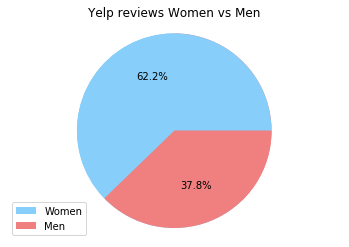

In [28]:
total_reviews = df_total['gender'].value_counts()

plt.clf()
colors = ['lightskyblue', 'lightcoral']
labels = ['Women','Men']
patches, texts = plt.pie(total_reviews, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.pie(total_reviews, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
# plt.tight_layout()
plt.title("Yelp reviews Women vs Men")
plt.savefig("Images/Women_vw_Men_all.png")

print(total_reviews)


price
$       288
$$      585
$$$      98
$$$$     41
Name: price, dtype: int64

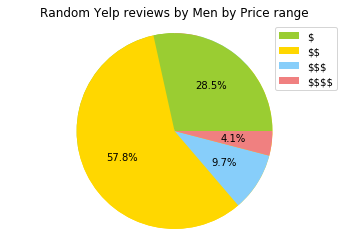

In [29]:
# use line below to bypass API calls
# df_total = pd.read_csv('output/total_everything_all.csv')

men_sizes = []
df_only_men = df_total.loc[(df_total["gender"] == 'Male')]

df_only_men_price_count = df_only_men.loc[(df_only_men["price"] != '*')]
# df_only_men_price_count = df_only_men.loc[(df_only_men["reviewer_rating"] != '*')]

df_only_men_price_count_gb = df_only_men_price_count.groupby(['price'])
# df_only_men_price_count_gb = df_only_men_price_count.groupby(['reviewer_rating'])

men_sizes = df_only_men_price_count_gb['price'].count()
# men_sizes = df_only_men_price_count_gb['reviewer_rating'].count()

# avg_rating_men = df_only_men_price_count['reviewer_rating'].mean()
# print(avg_rating_men)

plt.clf()
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
labels = ['\$','\$\$','\$\$\$','\$\$\$\$']

patches, texts = plt.pie(men_sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.pie(men_sizes, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
# plt.tight_layout()
plt.title("Random Yelp reviews by Men by Price range")
plt.savefig("Images/Men_Price_Reviews_all.png")
# df_only_men_price_count['reviewer_rating'].value_counts()
men_sizes
# df_total.head(50)

4.228178090216755


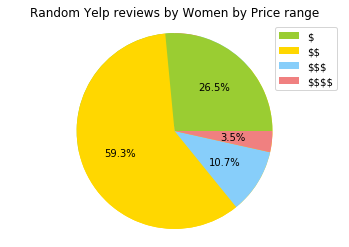

price
$       442
$$      989
$$$     178
$$$$     58
Name: price, dtype: int64

In [30]:
women_sizes = []
df_only_women = df_total.loc[(df_total["gender"] == 'Female')]

df_only_women_price_count = df_only_women.loc[(df_only_women["price"] != '*')]
# df_only_women_price_count = df_only_women.loc[(df_only_women["reviewer_rating"] != '*')]

df_only_women_price_count_gb = df_only_women_price_count.groupby(['price'])
# df_only_women_price_count_gb = df_only_women_price_count.groupby(['reviewer_rating'])

women_sizes = df_only_women_price_count_gb['price'].count()
# women_sizes = df_only_women_price_count_gb['reviewer_rating'].count()

avg_rating_women = df_only_women_price_count['rating'].mean()
print(avg_rating_women)

plt.clf()
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
labels = ['\$','\$\$','\$\$\$','\$\$\$\$']
patches, texts = plt.pie(men_sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.pie(women_sizes, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
# plt.tight_layout()
plt.title("Random Yelp reviews by Women by Price range")
plt.savefig("Images/Women_Price_Reviews_all.png")
plt.show()
women_sizes

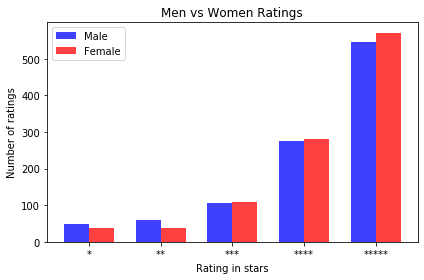

In [31]:
df_total_male = df_total.loc[df_total['gender']=='Male']
df_total_female = df_total.loc[df_total['gender']=='Female']

max_men = df_total_male['reviewer_rating'].count()
df_total_female = df_total_female.iloc[0:max_men,:]

df_total_m_f = df_total_male
df_total_m_f = df_total_m_f.append(df_total_female)

df_summary_reviews_gb = df_total_m_f.groupby(['reviewer_rating','gender'])
df_summary_reviews = pd.DataFrame(df_summary_reviews_gb['review_id'].count())
df_summary_pivot = df_summary_reviews.pivot_table('review_id','reviewer_rating','gender')
df_summary_pivot
n_groups = 5

female = df_summary_pivot['Female'].astype(int)
male = df_summary_pivot['Male'].astype(int)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.75

rects1 = plt.bar(index, male, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Male')

rects2 = plt.bar(index + bar_width, female, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Female')

plt.xlabel("Rating in stars")
plt.ylabel("Number of ratings")
plt.savefig("Images/Men_vs_Women_Rating.png")
plt.title("Men vs Women Ratings")
plt.xticks(index + bar_width / 2, ('*', '**', '***', '****', '*****'))
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
# df_total.head()
df_zipcodes = df_total.groupby(['zip_code','gender'])
df_zipcodes_count = pd.DataFrame(df_zipcodes['review_count'].sum())

df_zipcodes_pivot = df_zipcodes_count.pivot_table('review_count','zip_code','gender')
df_zipcodes_pivot = df_zipcodes_pivot.fillna(0)
df_zipcodes_pivot['total'] = (df_zipcodes_pivot['Female']+df_zipcodes_pivot['Male'])
df_zipcodes_pivot['pct_female'] = (df_zipcodes_pivot['Female'])/(df_zipcodes_pivot['Female']+df_zipcodes_pivot['Male'])
df_zipcodes_pivot['pct_male'] = (df_zipcodes_pivot['Male'])/(df_zipcodes_pivot['Female']+df_zipcodes_pivot['Male'])

# Specify the file to write to
output_path = os.path.join("output", "reviewcount_gender_zipcode_all.csv")
df_zipcodes_pivot.to_csv(output_path)

df_zipcodes_pivot.total.sum()

3678197.0

In [35]:
# Run statistics for gender vs price
female_price = df_total.loc[(df_total["gender"]=='Female') , ["price_num"]]
male_price = df_total.loc[(df_total["gender"]=='Male'), ["price_num"]]

female_price = female_price.fillna(0)
male_price = male_price.fillna(0)

fem_avg = female_price.mean()
male_avg = male_price.mean()

print(f"Average Female: {fem_avg}, Average Male: {male_avg}")
stats.ttest_ind(female_price, male_price, equal_var=False)

Average Female: price_num    1.866432
dtype: float64, Average Male: price_num    1.849421
dtype: float64


Ttest_indResult(statistic=array([0.56158157]), pvalue=array([0.57445976]))

In [36]:
# Run statistics for gender vs rating
female_rating = df_total.loc[df_total["gender"]=='Female', ["reviewer_rating"]]
male_rating = df_total.loc[df_total["gender"]=='Male', ["reviewer_rating"]]

fem_avg = female_rating.mean()
male_avg = male_rating.mean()

print(f"Average Female: {fem_avg}, Average Male: {male_avg}")

stats.ttest_ind(female_rating, male_rating, equal_var=False)

Average Female: reviewer_rating    4.239602
dtype: float64, Average Male: reviewer_rating    4.164093
dtype: float64


Ttest_indResult(statistic=array([1.74664323]), pvalue=array([0.08084786]))